## Installs


In [1]:

import torch
from torch import nn, optim
from sae import AutoEncoder
import scanpy as sc
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

## Dataset

In [2]:
import scanpy as sc

def split_data(X, subject_ids, unique_ids):
  unique_ids = subject_ids.unique()
  data = [[] for _ in range(X.shape[1])]
  sizes = [[] for _ in range(X.shape[1])]
  for i in range(X.shape[1]):
    for j, subject_id in enumerate(unique_ids):
      subject_indices = subject_ids == subject_id
      subject_data = X[subject_indices, i]
      data[i].append(torch.from_numpy(subject_data.toarray()))
      sizes[i].append(torch.tensor([subject_data.shape[0]],dtype = torch.int32))
  return data, sizes

def collate(batch):
      """
      x = torch.cat(data[0], dim=0)
      sizes = torch.cat(sizes[0], dim=0)
      batch = torch.arange(sizes.numel()).repeat_interleave(sizes)
      """
      data = [item[0] for item in batch]
      sizes = [item[1] for item in batch]
      target = [item[2] for item in batch]
      gene = [item[3] for item in batch]
      subject = [item[4] for item in batch]
      x = torch.cat(data, dim=0)
      sizes = torch.cat([item[1] for item in batch], dim=0)
      batch = torch.arange(sizes.numel()).repeat_interleave(sizes)
      target = torch.Tensor(target)
      gene = torch.LongTensor(gene)
      subject = torch.LongTensor(subject)
      return x, batch, target, gene, subject

class SCDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        adata,
        phenotypes,
        d_output=2, # default binary classification
        dest_path="/content", # default for colab
        return_augs=False,
    ):

        self.return_augs = return_augs
        self.d_output = d_output  # needed for decoder to grab
        self.adata = adata
        self.X  = self.adata.X

        self.num_genes = self.X.shape[1]

        self.subject_ids = self.adata.obs["subject_id"]
        self.unique_ids = self.subject_ids.unique()
        self.num_subjects = len(self.unique_ids)

        self.data, self.sizes = split_data(self.X, self.subject_ids, self.unique_ids)

        self.phenotypes = phenotypes
        self.labels = [self.phenotypes[self.phenotypes['Sample_ID']==int(unique_id)]['binary_y'] for unique_id in self.unique_ids]

    def __len__(self):
        return self.num_genes*self.num_subjects

    def __getitem__(self, idx):
        gene = idx // self.num_subjects
        subject = idx % self.num_subjects
        x = self.data[gene][subject]
        size = self.sizes[gene][subject]
        target = self.labels[subject].item()
        return x, size, target, gene, subject

## Autoencoder Training

In [56]:
def train_autoencoder(model, device, train_loader, optimizer, epoch, log_interval=5000):
    """Training loop."""
    model.train()
    for batch_idx, (data, size, _,_,_) in enumerate(train_loader):
        data, size = data.to(device), size.to(device)
        optimizer.zero_grad()
        xr, batchr = model(data, size)
        loss_data = model.loss()
        loss = loss_data["loss"]
        loss.backward()
        optimizer.step()


In [4]:
def test_autoencoder(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, size, _ ,_,_ in test_loader:
            data, size = data.to(device), size.to(device)
            xr, batchr = model(data, size)
            loss_data = model.loss()
            loss = loss_data["loss"]
            test_loss += loss  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print(f"Test Loss: {test_loss}")
    #changed
    return test_loss

In [21]:
def run_train_autoencoder(test_subjects=None, hidden_dim =6, weight_decay=.01):

    # experiment settings:
    num_epochs = 200
    batch_size = 8
    learning_rate = .005  
    weight_decay = weight_decay

    
    hidden_dim = hidden_dim
    dim = 1
    device = 'cuda' if torch.cuda.is_available() else 'cpu'   

    print("Using device:", device)
    

    adata = sc.read("./processed_dataset_16genes.h5ad")
    max_n = adata.obs['subject_id'].value_counts().max()
    model = AutoEncoder(dim=dim, hidden_dim=hidden_dim, max_n=max_n)
    model.to(device)
    phenotypes = pd.read_csv('phenotypes_16gene.csv')
    if test_subjects:
      train_adata = adata[~adata.obs['subject_id'].isin(test_subjects), :]
      test_adata = adata[adata.obs['subject_id'].isin(test_subjects), :]
      train_phenotypes = phenotypes[~phenotypes['Sample_ID'].isin([int(s) for s in test_subjects])]
      test_phenotypes = phenotypes[phenotypes['Sample_ID'].isin([int(s) for s in test_subjects])]

    else:
      train_adata = adata
      test_adata = None
      train_phenotypes = phenotypes
      test_phenotypes = None
    # create datasets
    ds_train = SCDataset(
        adata=train_adata,
        phenotypes=train_phenotypes,
        d_output=2,
        dest_path="/content",
        return_augs=False,
    )
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn = collate)
    if test_adata:
      ds_test = SCDataset(
          adata=test_adata,
          phenotypes=test_phenotypes,
          d_output=2,
          dest_path="/content",
          return_augs=False,
      )
      test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, collate_fn = collate)


    # create optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.to(device)
    accuracies = []
    train_losses = []
    best = 1000000
    best_state_dict = None
    patience = 5
    epoch_since_update = 0

    for epoch in range(num_epochs):
        train_autoencoder(model, device, train_loader, optimizer, epoch)
        if test_adata:
          accuracy = test_autoencoder(model, device, test_loader)
          train_loss = test_autoencoder(model, device, train_loader)
          accuracies.append(accuracy)
          train_losses.append(train_loss)
          if best - accuracy > 0.00:
            best = accuracy
            best_state_dict = model.state_dict()
            epoch_since_update = 0
          else:
            epoch_since_update +=1
            if epoch_since_update >= patience:
              model.load_state_dict(best_state_dict)
              break

        optimizer.step()

    return model, accuracies, train_losses, ds_train, ds_test

### Search hyperparameters

In [ ]:
test_subjects = ['1','15','3']
hidden_dims = [4,6,8,]
weight_decay = [0, 0.001, 0.01, 0.1]
accuracies = []
autoencoders = []
params = []
for hidden_dim in hidden_dims:
  for weight in weight_decay:
    model, accuracy, ds_train, ds_test = run_train_autoencoder(test_subjects = test_subjects, hidden_dim=hidden_dim, weight_decay=weight)
    accuracies.append(accuracy)
    autoencoders.append(model)
    params.append((hidden_dim, weight))

In [ ]:
accuracies[0]

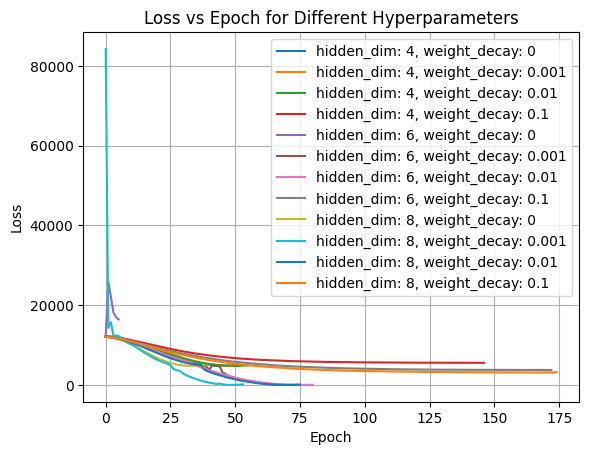

'\nfor param, acc in zip(params[10:], accuracies[10:]):\n    if param[1] == 0 and param[0] == 10:\n        continue\n    accuracy = [a.detach().cpu().numpy() for a in acc]\n    plt.plot(range(len(accuracy)),accuracy, label = f"hidden_dim: {param[0]}, weight_decay: {param[1]}")\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Loss\')\nplt.title(\'Loss vs Epoch for Different Hyperparameters\')\nplt.legend()\nplt.grid()\nplt.show()\n'

In [36]:
for param, acc in zip(params, accuracies):
    accuracy = [a.detach().cpu().numpy() for a in acc]
    plt.plot(range(len(accuracy)),accuracy, label = f"hidden_dim: {param[0]}, weight_decay: {param[1]}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for Different Hyperparameters')
plt.legend()
plt.grid()
plt.show()

"""
for param, acc in zip(params[10:], accuracies[10:]):
    if param[1] == 0 and param[0] == 10:
        continue
    accuracy = [a.detach().cpu().numpy() for a in acc]
    plt.plot(range(len(accuracy)),accuracy, label = f"hidden_dim: {param[0]}, weight_decay: {param[1]}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for Different Hyperparameters')
plt.legend()
plt.grid()
plt.show()
"""


### train autoencoder

In [22]:
autoencoder, accuracies, train_loss, ds_train, ds_test = run_train_autoencoder(test_subjects = ['1','15','3'],hidden_dim=6, weight_decay=0.01)

Using device: cuda


/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rand/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/rand/github/XMED521/proj/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel

Train Epoch: 0 [0/34 (0%)]	Loss: 254054.562500


/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Test Loss: 116433.53125
Test Loss: 742692.875
Train Epoch: 1 [0/34 (0%)]	Loss: 1898222.250000
Test Loss: 12089.1357421875
Test Loss: 37376.671875
Train Epoch: 2 [0/34 (0%)]	Loss: 346911.468750
Test Loss: 12018.8154296875
Test Loss: 37257.828125
Train Epoch: 3 [0/34 (0%)]	Loss: 190622.468750
Test Loss: 11928.32421875
Test Loss: 37104.34375
Train Epoch: 4 [0/34 (0%)]	Loss: 726010.937500
Test Loss: 11822.640625
Test Loss: 36924.6796875
Train Epoch: 5 [0/34 (0%)]	Loss: 182011.562500
Test Loss: 11698.65625
Test Loss: 36713.2734375
Train Epoch: 6 [0/34 (0%)]	Loss: 415582.093750
Test Loss: 11554.044921875
Test Loss: 36465.6875
Train Epoch: 7 [0/34 (0%)]	Loss: 377305.187500
Test Loss: 11399.380859375
Test Loss: 36199.609375
Train Epoch: 8 [0/34 (0%)]	Loss: 176688.250000
Test Loss: 11220.703125
Test Loss: 35890.58984375
Train Epoch: 9 [0/34 (0%)]	Loss: 188777.890625
Test Loss: 11026.54296875
Test Loss: 35552.75390625
Train Epoch: 10 [0/34 (0%)]	Loss: 243558.109375
Test Loss: 10828.802734375
Tes

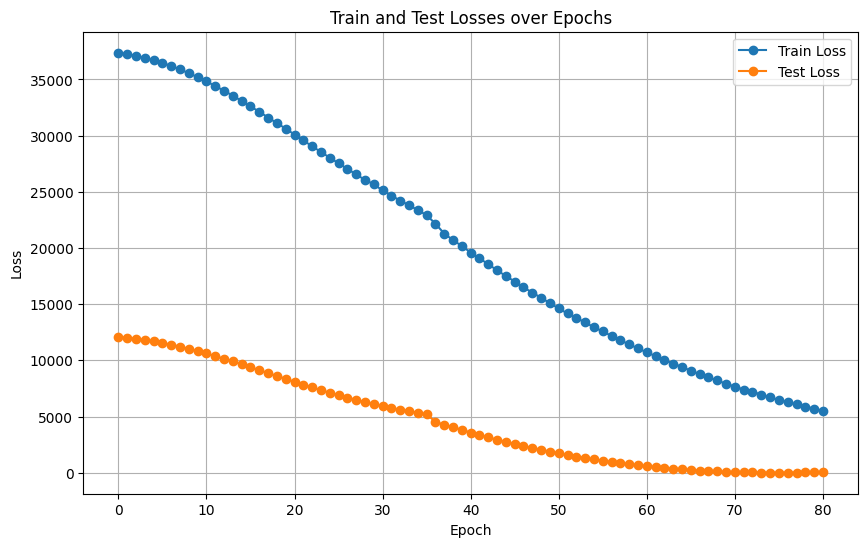

In [ ]:
plt.figure(figsize=(10, 6))
train_l = [t.detach().cpu().numpy() for t in train_loss]
test_l = [a.detach().cpu().numpy() for a in accuracies]
plt.plot(range(len(train_l)-1), train_l[1:], label='Train Loss', marker='o')
plt.plot(range(len(test_l)-1), test_l[1:], label='Test Loss', marker='o')

# Add axis labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a title
plt.title('Train and Test Losses over Epochs')

# Add a legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Encodings Dataset

In [27]:
def generate_embeddings(embedding_model, ds):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    loader = DataLoader(ds, batch_size=1, shuffle=False, collate_fn = collate)
    embeddings = []
    labels = []
    genes = []
    subjects = []
    with torch.no_grad():
        for data, size, y, gene, subject in loader:
            data, size = data.to(device), size.to(device)
            embedding = embedding_model(data, size)
            embeddings.append(embedding)
            labels.append(y)
            genes.append(gene.cpu().item())
            subjects.append(subject.cpu().item())
    return torch.stack(embeddings, axis=0).squeeze(), torch.stack(labels,axis=0), genes, subjects


In [28]:
embeddings_train, y_train , genes_train, subjects_train = generate_embeddings(autoencoder.encoder, ds_train)
embeddings_test, y_test, genes_test, subjectes_test = generate_embeddings(autoencoder.encoder, ds_test)

In [29]:
def reshape_tensor_label(tensor, labels, gene_ids, subject_ids, num_genes, num_subjects):

    embedding_dim = tensor.shape[1]  # Get embedding dimension
    reshaped_tensor = torch.zeros((num_genes, num_subjects, embedding_dim))
    reshaped_labels = torch.zeros((num_genes, num_subjects))
    for i in range(tensor.shape[0]):
        gene_index = gene_ids[i]
        subject_index = subject_ids[i]
        reshaped_tensor[gene_index, subject_index] = tensor[i]
        reshaped_labels[gene_index, subject_index] = labels[i].item()
    return reshaped_tensor, reshaped_labels

In [30]:
reshaped_embeddings_train, reshaped_labels_train = reshape_tensor_label(embeddings_train, y_train, genes_train, subjects_train, ds_train.num_genes, ds_train.num_subjects)
reshaped_embeddings_test, reshaped_labels_test = reshape_tensor_label(embeddings_test, y_test, genes_test, subjectes_test, ds_test.num_genes, ds_test.num_subjects)

In [31]:
def transform_split(tensor, labels, split = 1):
  transformed = tensor.reshape(tensor.shape[1],tensor.shape[0]*tensor.shape[2])
  labels = labels[0,:]
  split1 = int(tensor.shape[1]*split)
  tensor1 = transformed[:split1,:]
  tensor2 = transformed[split1:,:]
  labels1 = labels[:split1]
  labels2 = labels[split1:]
  return tensor1, tensor2, labels1, labels2


In [32]:
x, _,y,_ = transform_split(reshaped_embeddings_train, reshaped_labels_train)
xval, _, yval, _ = transform_split(reshaped_embeddings_test, reshaped_labels_test)

In [33]:
embeddings = torch.cat((x, xval), axis=0)
y_cat = torch.cat((y, yval), axis=0)



In [23]:
embeddings.shape

torch.Size([20, 96])

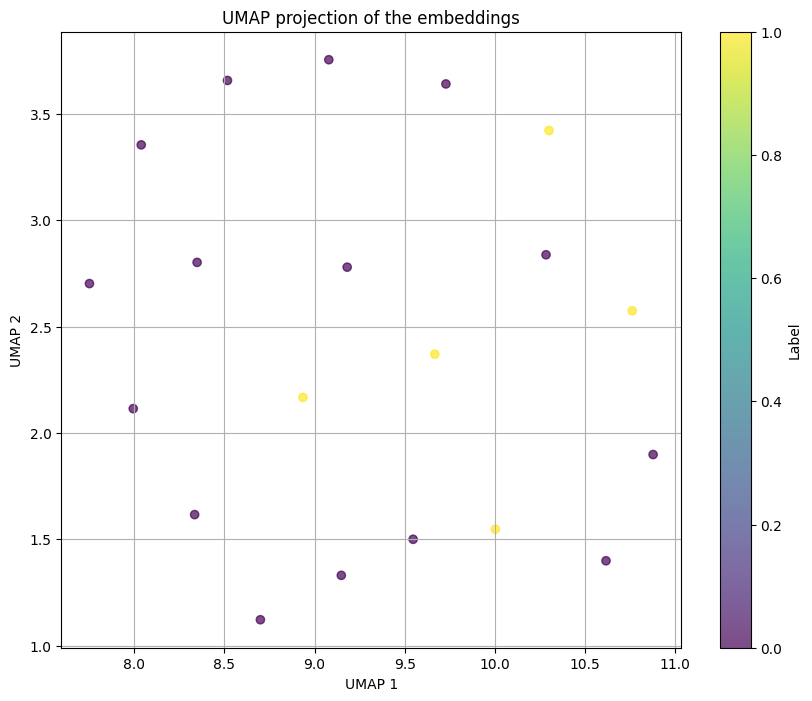

In [30]:
import umap

import matplotlib.pyplot as plt

# Combine the train and test embeddings

# Perform UMAP
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embeddings.cpu().numpy())


# Plot the UMAP results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=y_cat.cpu().numpy(), cmap= 'viridis', alpha=0.7)

plt.colorbar(scatter, label='Label')
plt.title('UMAP projection of the embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

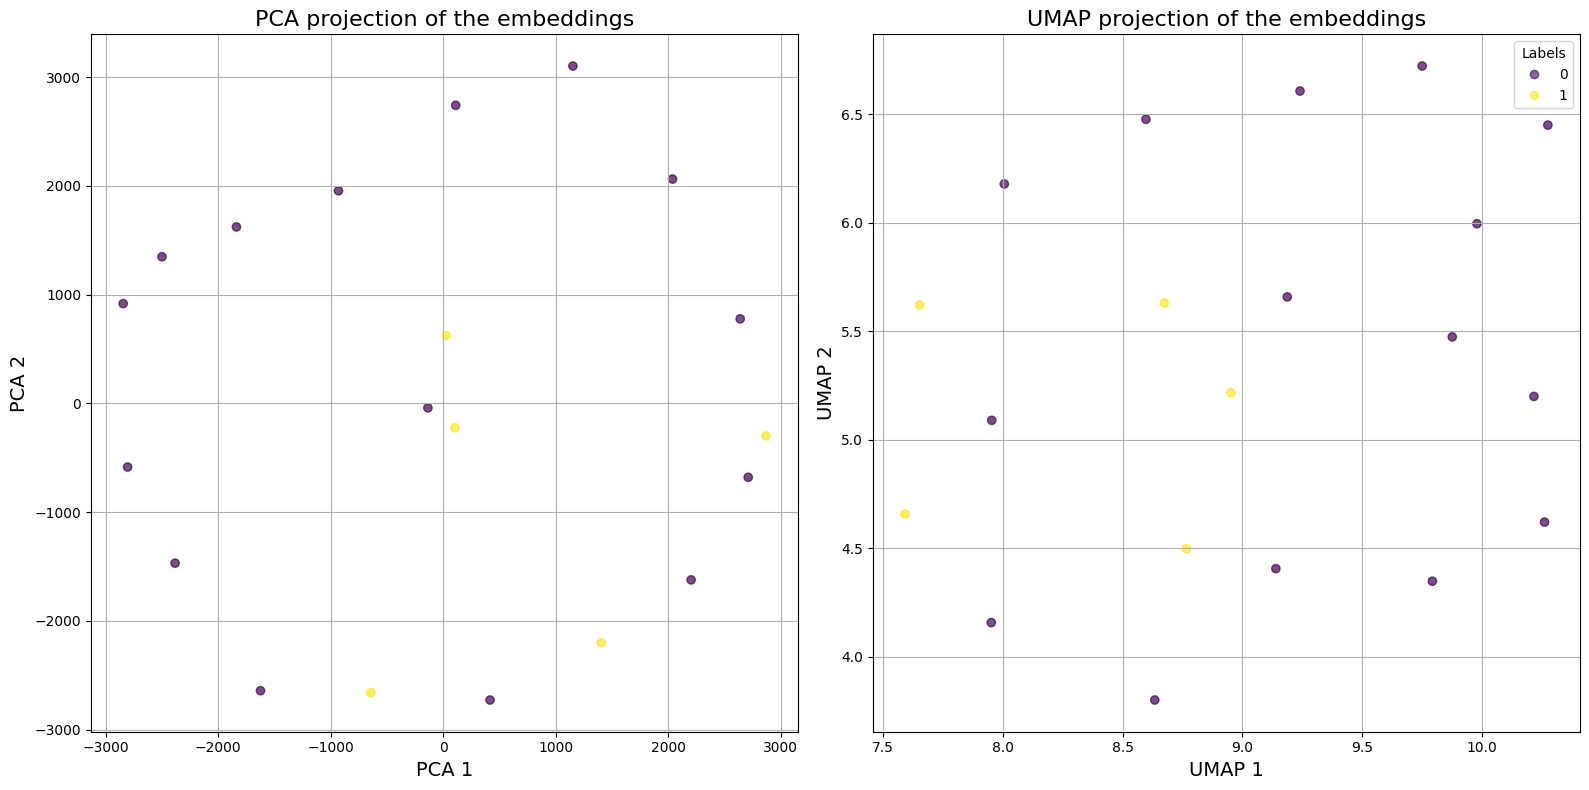

In [35]:
from sklearn.decomposition import PCA
import umap

import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings.cpu().numpy())

# Perform UMAP
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embeddings.cpu().numpy())

# Plot the PCA and UMAP results side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot PCA
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=y_cat.cpu().numpy(), cmap='viridis', alpha=0.7)
axes[0].set_title('PCA projection of the embeddings', fontsize=16, )
axes[0].set_xlabel('PCA 1', fontsize=14)
axes[0].set_ylabel('PCA 2', fontsize=14)
axes[0].grid(True)

# Plot UMAP
scatter = axes[1].scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=y_cat.cpu().numpy(), cmap='viridis', alpha=0.7)
axes[1].set_title('UMAP projection of the embeddings', fontsize=16, )
axes[1].set_xlabel('UMAP 1', fontsize=14)
axes[1].set_ylabel('UMAP 2', fontsize=14)
axes[1].grid(True)
# Add a legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend_labels = ['0', '1']
plt.legend(handles, legend_labels, title="Labels")

#plt.colorbar(scatter, label='Label')
plt.tight_layout()
plt.show()

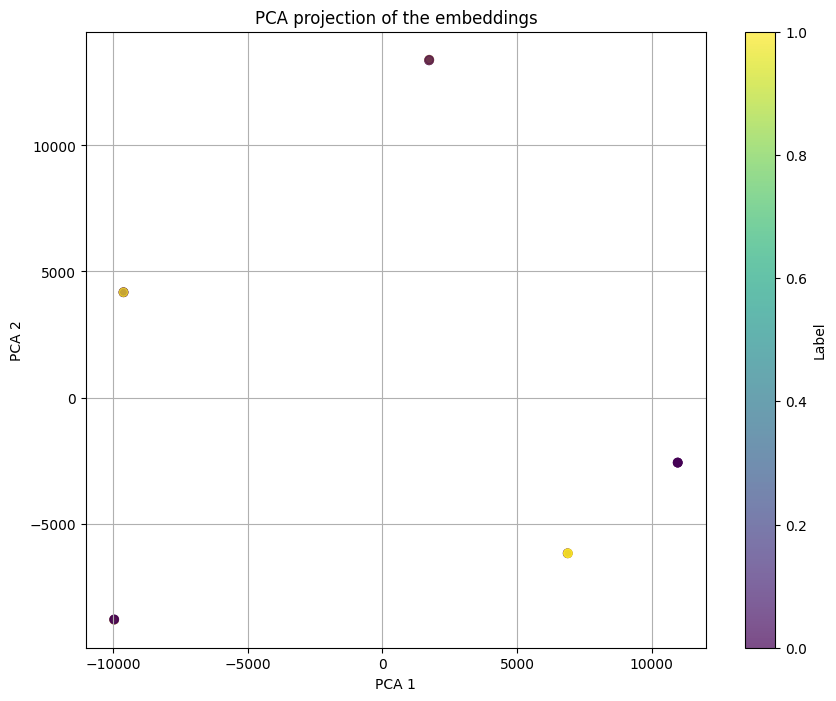

In [50]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(x.cpu().numpy())

# Plot the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_cat.cpu().numpy(), cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Label')
plt.title('PCA projection of the embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

## Prediction Models

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):     
        super(LinearLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        scale = 1. * np.sqrt(6. / (input_dim + output_dim))
        # approximated posterior
        self.w = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-scale, scale))
        self.bias = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-scale, scale))

    def forward(self, x):     
        return torch.mm(x, self.w) + self.bias   

    
class Predictor(nn.Module):
    def __init__(self, gene_size, hidden_dim, beta):
        super(Predictor, self).__init__()
        self.input_dim = gene_size
        
        self.Layer1 = LinearLayer(self.input_dim, hidden_dim)
        self.Layer2 = LinearLayer(hidden_dim, 1)
        self.activation_fn = nn.Softplus(beta = beta)
        
    def forward(self, x):
        x1 = self.activation_fn(self.Layer1(x))
        x2 = self.Layer2(x1)
        output = torch.sigmoid(x2)
        return output, self.reg_layers()
    
    def reg_layers(self):
        reg = torch.norm(self.Layer1.w, 1) + torch.norm(self.Layer2.w, 1)
        return reg 
    

class Main_effect(nn.Module):
    def __init__(self, gene_size):
        super(Main_effect, self).__init__()
        self.input_dim = gene_size
        self.Layer1 = LinearLayer(self.input_dim, 1)

    def forward(self, x):
        x1 = self.Layer1(x)
        return torch.sigmoid(x1), self.reg_layers()

    def reg_layers(self):
        reg = torch.norm(self.Layer1.w, 1)
        return reg



## Train Gene Interaction NN and Main Effect

In [37]:
def train_predictor(model, device, train_loader, optimizer, epoch,loss_fn, reg_weight, lambda_l1):
    """Training loop."""
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, reg = model(data)
        loss = loss_fn(output, target)+ reg_weight * reg
        #for param in model.parameters():
        #    loss += lambda_l1 * torch.sum(torch.abs(param))
        loss.backward()
        optimizer.step()


In [38]:
def test_predictor(model, device, test_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, reg = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.round()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (100.* correct / len(test_loader.dataset)), test_loss

### Train Gene Interactoin

In [39]:
def run_train_predictor(x, y, xval, yval, beta=10, learning_rate=.0008, regularization=.001, hidden_dim=19):
    learning_rate = learning_rate
    epochs = 100
    reg_weight = regularization

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    input_dim = x.shape[1]

    model = Predictor(input_dim, hidden_dim, beta)  

    train_dl = DataLoader(TensorDataset(x, y.unsqueeze(1)), batch_size=1, shuffle=True)
    test_dl = DataLoader(TensorDataset(xval, yval.unsqueeze(1)), batch_size=1, shuffle=False)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-8)
    model.to(device)
    accuracies_train = []
    losses_train = []
    accuracies_test = []
    losses_test = []
    best = 1000000
    best_state_dict = None
    patience = 8
    epoch_since_update = 0
    for epoch in range(epochs):
        train_predictor(model, device, train_dl, optimizer, epoch, loss_fn, reg_weight=reg_weight,lambda_l1 = 0.02) 
        accuracy_train, loss_train = test_predictor(model, device, train_dl, loss_fn)
        accuracy_test, loss_test = test_predictor(model, device, test_dl, loss_fn)
        accuracies_train.append(accuracy_train)
        losses_train.append(loss_train)
        accuracies_test.append(accuracy_test)
        losses_test.append(loss_test)
        if best - loss_test >0:
            best = loss_test
            best_state_dict = model.state_dict()
            epoch_since_update = 0
        else:
            epoch_since_update +=1
            if epoch_since_update >= patience:
              model.load_state_dict(best_state_dict)
              break

        optimizer.step()
    return model, accuracies_test, losses_test, accuracies_train, losses_train



In [40]:
from sklearn.model_selection import KFold

def k_fold_cross_validation(x, y, learning_rate, regularization, hidden_dim,  k=5, beta=5,):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_losses = []
    train_accuracies = []
    train_losses = []
    models = []
    for train_index, val_index in kf.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        predictor, test_accuracies, test_losses, train_accuracy, train_loss = run_train_predictor(x_train, y_train, x_val, y_val, beta=beta, learning_rate=learning_rate, regularization=regularization, hidden_dim=hidden_dim)
        fold_accuracies.append(test_accuracies)
        fold_losses.append(test_losses)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        models.append(predictor)

    return fold_accuracies, fold_losses, train_accuracies, train_losses, models



In [28]:
y_bin = [int(y) for y in y_bin]
y_bin = torch.tensor(y_bin, dtype=torch.float32)

In [94]:
def grid_search(embeddings, y_bin):
    learning_rates = [.0008,]
    regularizations = [.001,]
    betas = [10]
    hidden_dims = [19,]
    losses = []
    accuracies = []
    params = []
    for lr in learning_rates:
        for reg in regularizations:
            for beta in betas:
                for hidden_dim in hidden_dims:
                    fold_accuracies, fold_losses = k_fold_cross_validation(embeddings, y_bin, k=5, beta=5, learning_rate = lr, regularization=reg, hidden_dim=hidden_dim)
                    avg_accuracy = np.mean([a[-1] for a in fold_accuracies])
                    avg_loss = np.mean([l[-1] for l in fold_losses])
                    var_accuracy = np.var([a[-1] for a in fold_accuracies])
                    var_loss = np.var([l[-1] for l in fold_losses])
                    losses.append((avg_loss, var_loss))
                    accuracies.append((avg_accuracy, var_accuracy))
                    params.append((lr, reg, beta, hidden_dim))
                    print(f"lr: {lr}, reg: {reg}, beta: {beta}, hidden_dim: {hidden_dim}, avg_accuracy: {avg_accuracy}, avg_loss: {avg_loss}")
    return losses, accuracies, params

In [95]:
losses, accuracies, params = grid_search(embeddings, y_bin)

TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 18 19] VAL: [ 0  1 15 17]

Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)

TRAIN: [ 0  1  2  4  6  7  9 10 12 13 14 15 16 17 18 19] VAL: [ 3  5  8 11]

Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0422, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Ac

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Extract the parameters for the x-axis labels
learning_rates = [param[0] for param in params]
regularizations = [param[1] for param in params]
betas = [param[2] for param in params]
hidden_dims = [param[3] for param in params]

# Extract the average losses and accuracies for the y-axis values
avg_losses = [loss[0] for loss in losses]
avg_accuracies = [accuracy[0] for accuracy in accuracies]
sorted_indices_acc = np.argsort(avg_accuracies)
sorted_avg_accuracies = np.array(avg_accuracies)[sorted_indices_acc]



#sorted_var_accuracies = np.array(var_accuracies)[sorted_indices_acc]
sorted_params_acc = np.array(params)[sorted_indices_acc]
sorted_indices_loss = np.argsort(avg_losses)[::-1]
sorted_avg_losses = np.array(avg_losses)[sorted_indices_loss]
#sorted_var_losses = np.array(var_losses)[sorted_indices_loss]
sorted_params_loss = np.array(params)[sorted_indices_loss]

# Define a function to create bar graphs
def create_bar_graph(values, params, i, param_name, title, ylabel, color_map):
    param_values = [param[i] for param in params]
    
    unique_params = sorted(set(param_values))
    colors = plt.cm.get_cmap(color_map, len(unique_params))

    plt.figure(figsize=(18, 6))
    for i, param in enumerate(unique_params):
        indices = [j for j, x in enumerate(param_values) if x == param]
        plt.bar(indices, [values[j] for j in indices], color=colors(i), alpha=0.7, label=f'{param_name}: {param}')

    plt.xlabel('Parameter Set Index')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(range(len(params)), [f'LR: {lr}, Reg: {reg}, Beta: {beta}, HD: {hd}' for lr, reg, beta, hd in params], rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create bar graphs for average losses
create_bar_graph(sorted_avg_losses, sorted_params_loss, 0, 'Learning Rate', 'Average Loss for Different Learning Rates', 'Average Loss', 'viridis')
create_bar_graph(sorted_avg_losses, sorted_params_loss,1, 'Regularization', 'Average Loss for Different Regularizations', 'Average Loss', 'plasma')
create_bar_graph(sorted_avg_losses, sorted_params_loss,2, 'Beta', 'Average Loss for Different Betas', 'Average Loss', 'inferno')
create_bar_graph(sorted_avg_losses, sorted_params_loss,3, 'Hidden Dimension', 'Average Loss for Different Hidden Dimensions', 'Average Loss', 'magma')

# Create bar graphs for average accuracies
create_bar_graph(sorted_avg_accuracies, sorted_params_loss,0, 'Learning Rate', 'Average Accuracy for Different Learning Rates', 'Average Accuracy', 'viridis')
create_bar_graph(sorted_avg_accuracies, sorted_params_loss,1, 'Regularization', 'Average Accuracy for Different Regularizations', 'Average Accuracy', 'plasma')
create_bar_graph(sorted_avg_accuracies, sorted_params_loss,2, 'Beta', 'Average Accuracy for Different Betas', 'Average Accuracy', 'inferno')
create_bar_graph(sorted_avg_accuracies, sorted_params_loss,3, 'Hidden Dimension', 'Average Accuracy for Different Hidden Dimensions', 'Average Accuracy', 'magma')

In [43]:
accuracies_test, losses_test, accuracies_train, losses_train, predictors = k_fold_cross_validation(embeddings, y_cat, k=5, beta=5, learning_rate = .0007, regularization=.001, hidden_dim=19)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


Test set: Average loss: 13.7166, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


Test set: Average loss: 4.9776, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


Test set: Average loss: 1.8333, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


Test set: Average loss: 1.0675, Accuracy: 3/4 (75.00%)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


Test set: Average loss: 0.0014, Accuracy: 4/4 (100.00%)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


Test set: Average loss: 0.0000, Accuracy: 4/4 (100.00%)


Test set: Average loss: 25.0000, Accuracy: 12/16 (75.00%)


/tmp/ipykernel_32360/2662764.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(accuracies_test))


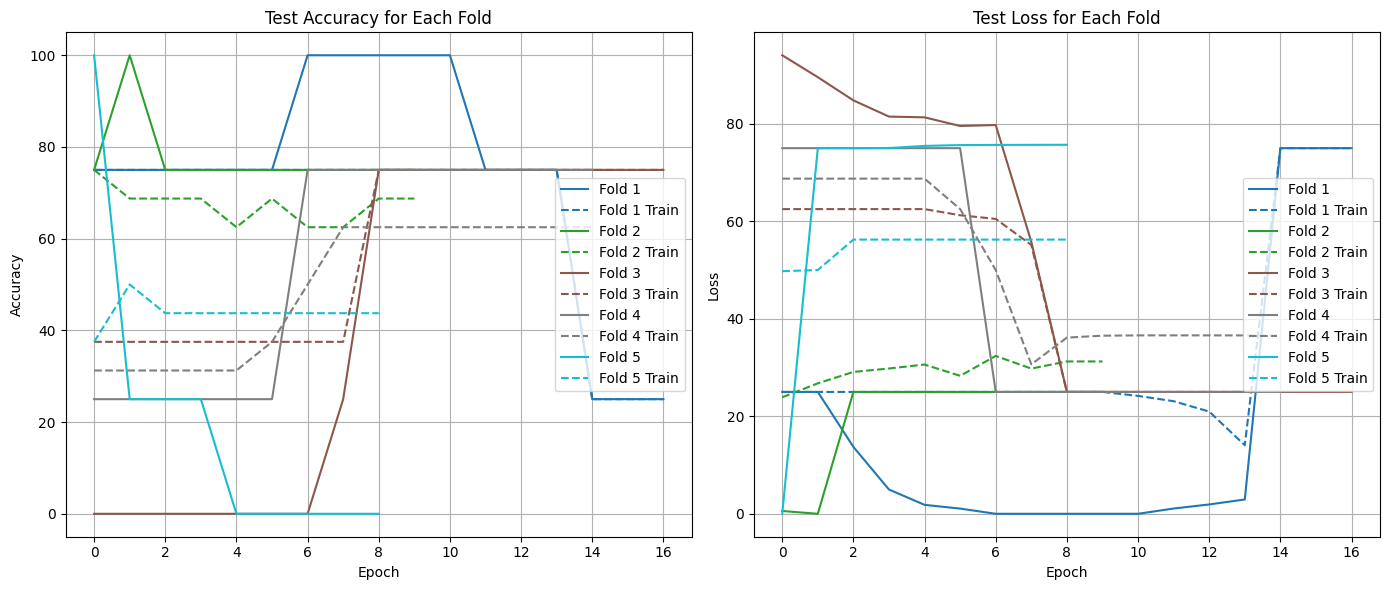

In [44]:
plt.figure(figsize=(14, 6))

# Define a color map
colors = plt.cm.get_cmap('tab10', len(accuracies_test))

# Plot accuracies
plt.subplot(1, 2, 1)
for i, fold_accuracy in enumerate(accuracies_test):
    plt.plot(range(len(fold_accuracy)), fold_accuracy, label=f'Fold {i+1}', color=colors(i))
    plt.plot(range(len(accuracies_train[i])), accuracies_train[i], label=f'Fold {i+1} Train', linestyle='--', color=colors(i))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Fold')
plt.legend()
plt.grid(True)

# Plot losses
plt.subplot(1, 2, 2)
for i, fold_loss in enumerate(losses_test):
    plt.plot(range(len(fold_loss)), fold_loss, label=f'Fold {i+1}', color=colors(i))
    plt.plot(range(len(losses_train[i])), losses_train[i], label=f'Fold {i+1} Train', linestyle='--', color=colors(i))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss for Each Fold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [101]:
predictor, accuracies_test, losses_test, accuracies_train, losses_train = run_train_predictor(x,y,xval,yval,)


Test set: Average loss: 82.3529, Accuracy: 3/17 (17.65%)


Test set: Average loss: 33.3333, Accuracy: 2/3 (66.67%)


Test set: Average loss: 82.3529, Accuracy: 3/17 (17.65%)


Test set: Average loss: 33.3333, Accuracy: 2/3 (66.67%)


Test set: Average loss: 82.3529, Accuracy: 3/17 (17.65%)


Test set: Average loss: 33.3333, Accuracy: 2/3 (66.67%)


Test set: Average loss: 82.3529, Accuracy: 3/17 (17.65%)


Test set: Average loss: 33.3333, Accuracy: 2/3 (66.67%)


Test set: Average loss: 82.3529, Accuracy: 3/17 (17.65%)


Test set: Average loss: 2.3483, Accuracy: 2/3 (66.67%)


Test set: Average loss: 77.0658, Accuracy: 3/17 (17.65%)


Test set: Average loss: 0.0000, Accuracy: 3/3 (100.00%)


Test set: Average loss: 65.5292, Accuracy: 5/17 (29.41%)


Test set: Average loss: 0.0000, Accuracy: 3/3 (100.00%)


Test set: Average loss: 56.1757, Accuracy: 6/17 (35.29%)


Test set: Average loss: 12.7461, Accuracy: 2/3 (66.67%)


Test set: Average loss: 13.7069, Accuracy: 14/17 (82.35%)


Test

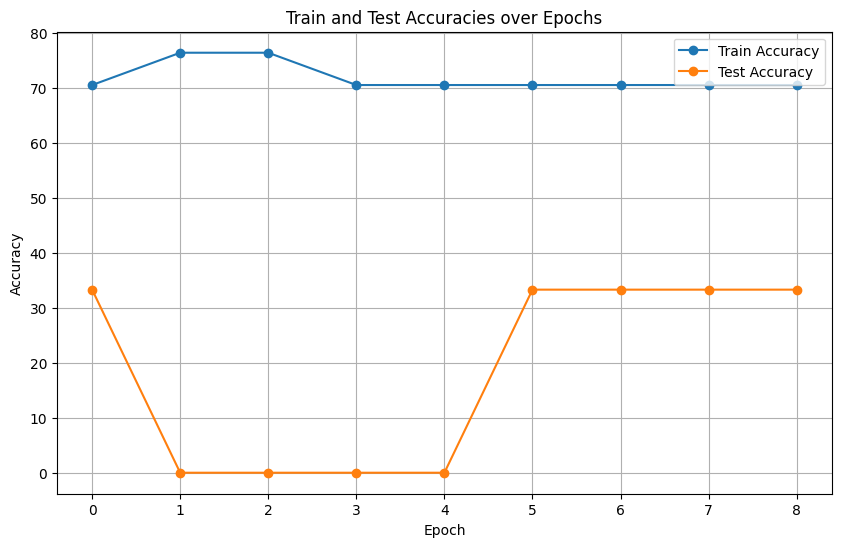

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies_train)), accuracies_train, label='Train Accuracy', marker='o')
plt.plot(range(len(accuracies_test)), accuracies_test, label='Test Accuracy', marker='o')

# Add axis labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add a title
plt.title('Train and Test Accuracies over Epochs')

# Add a legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

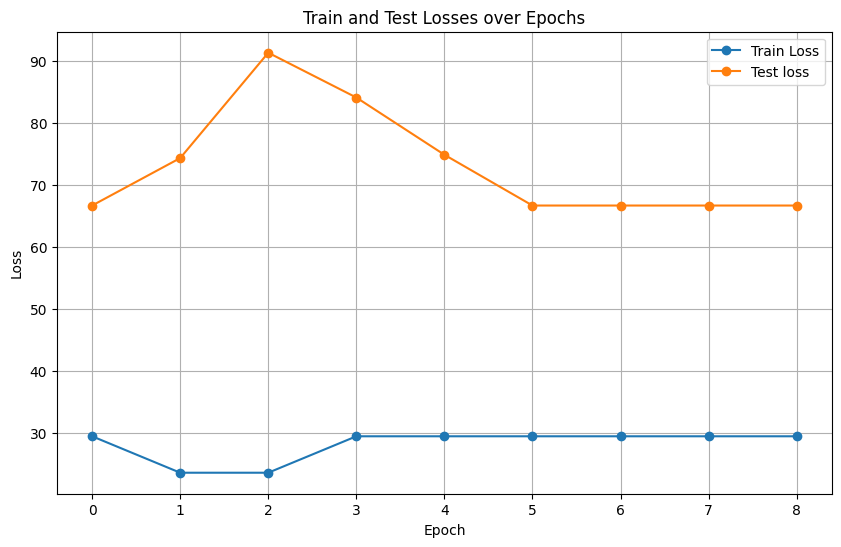

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses_train)), losses_train, label='Train Loss', marker='o')
plt.plot(range(len(losses_test)), losses_test, label='Test loss', marker='o')

# Add axis labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a title
plt.title('Train and Test Losses over Epochs')

# Add a legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

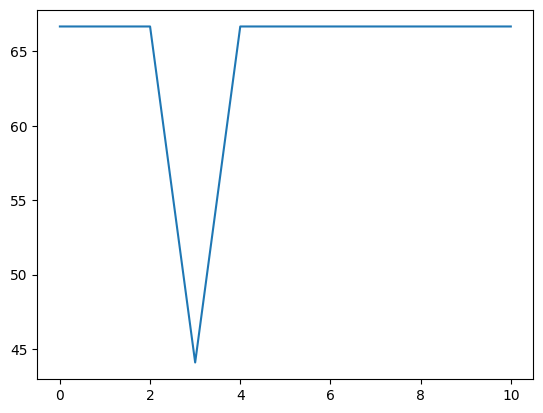

In [87]:
plt.plot(range(len(losses)),losses)

### Train Main Effect

In [102]:
def run_train_maineffect(x, y, xval, yval, beta):
    learning_rate = 0.002
    epochs = 100
    reg_weight = 0.01

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    input_dim = x.shape[1]
    hidden_dim = 32

    model = Main_effect(input_dim)  

    train_dl = DataLoader(TensorDataset(x, y.unsqueeze(1)), batch_size=1, shuffle=True)
    test_dl = DataLoader(TensorDataset(xval, yval.unsqueeze(1)), batch_size=1, shuffle=False)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-8)
    model.to(device)
    accuracies = []
    losses = []
    best = 1000000
    best_state_dict = None
    patience = 8
    epoch_since_update = 0
    for epoch in range(epochs):
        train_predictor(model, device, train_dl, optimizer, epoch, loss_fn, reg_weight=reg_weight,lambda_l1 = 0.02) 
        accuracy, loss = test_predictor(model, device, test_dl, loss_fn)
        if best - loss >0:
            best = loss
            best_state_dict = model.state_dict()
            epoch_since_update = 0
        else:
            epoch_since_update +=1
            if epoch_since_update >= patience:
              model.load_state_dict(best_state_dict)
              break
        accuracies.append(accuracy)
        losses.append(loss)
        optimizer.step()
    return model, accuracies, losses

In [69]:
maineffect_model, me_accuracies, me_losses = run_train_maineffect(x,y,xval,yval,beta =5) 

output: tensor([[0.1528]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[1.]], device='cuda:0'), pred: tensor([[1.]], device='cuda:0'), target: tensor([[0.]], device='cuda:0')

Test set: Average loss: 67.2928, Accuracy: 0/3 (0.00%)

output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[7.5835e-29]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[0.]], device='cuda:0')

Test set: Average loss: 66.6667, Accuracy: 1/3 (33.33%)

output: tensor([[1.7352e-16]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[0.]], de

## Shapley Taylor Interaction Index

In [45]:
import numpy as np
import torch
import torch.multiprocessing as mp

class ShapleyTaylorInteractionIndex:
    def __init__(self,
            encodings,
            predictor,
            device,
            num_permutations: int|None = None,
            ):
        """
        encodings expected dimension = (individuals,genes,gene_embedding dimension)

        """
        self.num_permutations = num_permutations
        self.encodings = encodings
        self.predictor = predictor
        self.predictor.eval()
        self.baseline = self.caluculate_baseline(self.encodings)
        self.num_individuals = self.encodings.shape[0]
        self.num_genes = self.encodings.shape[1]
        self.device = device

    def caluculate_baseline(self, encodings):
        #verify this is right
        baseline = torch.mean(encodings, dim =0)
        return baseline

    def generate_permutations(self, num_permutations, num_genes):
        permutations = [np.random.permutation(num_genes) for _ in range(num_permutations)]
        return permutations

    def generate_stratified_permutations(self, num_permutations, num_genes, encodings):
        pass

    def global_shapely_interaction_index(self, num_permutations,shapley_values = True):
        if not num_permutations:
            if not self.num_permutations:
                raise ValueError("num_permutations can not be none")
            else:
                num_permutations=self.num_permutations

        #intitialize matrix
        global_shapley_interactions = torch.zeros(size=(self.num_individuals,self.num_genes,self.num_genes))
        #make the permutation matrix
        permutations = self.generate_permutations(num_permutations,self.num_genes)
        """
        mp.set_start_method('spawn', force=True)  # Force if already set
        num_processes = mp.cpu_count()
        if num_processes > num_permutations:
          num_processes = num_permutations
        pool = mp.Pool(processes=num_processes)
        #iterate over individuals, could be parallelized
        results = pool.starmap(self.local_shapley_interaction_index, [(permutations,k, shapley_values) for k in range(self.num_individuals)])
        pool.close()
        pool.join()
        global_shapley_interactions = torch.stack(results, axis=0)
        """

        for k in range(self.num_individuals):
            global_shapley_interactions[k] = self.local_shapley_interaction_index(permutations,k, shapley_values)
            print(f"finished up to {k}")

        #check axis

        global_shapley_interactions = torch.mean(global_shapley_interactions,axis = 0)
        return global_shapley_interactions

    def local_shapley_interaction_index(self,permutations,k, shapley_values):
        local_shapley_interaction = torch.zeros(size=(len(permutations),self.num_genes,self.num_genes))
        if shapley_values:
            marginal_contribution = torch.zeros(size=(len(permutations),self.num_genes))
        for iter, pi in enumerate(permutations):
            s = []
            for i in pi:
                if i >=1: s.append(i-1)
                for j in pi[i+1:]:
                    local_shapley_interaction[iter,i,j] = self.interaction_score(s,i,j,k)
                if shapley_values:
                    marginal_contribution[iter,i] = self.marginal_contribution(s,i,k)
        local_shapley_interaction = torch.mean(local_shapley_interaction,axis=0)
        local_shapley_interaction = local_shapley_interaction + +local_shapley_interaction.T
        if shapley_values:
            local_shapley_interaction += torch.diag(torch.mean(marginal_contribution, axis =0))
        #maybe add shapley value here
        return local_shapley_interaction

    def interaction_score(self, s, i, j,k):
        s_ij = self.mask_input(s+[i,j],k).flatten().unsqueeze(0)
        s_i = self.mask_input(s+[i],k).flatten().unsqueeze(0)
        s_j = self.mask_input(s+[j],k).flatten().unsqueeze(0)
        s = self.mask_input(s,k).flatten().unsqueeze(0)
        with torch.no_grad():
            output_s_ij, _ = self.predictor(s_ij.to(self.device))
            output_s_i, _ = self.predictor(s_i.to(self.device))
            output_s_j, _ = self.predictor(s_j.to(self.device))
            output_s, _ = self.predictor(s.to(self.device))
        interaction_score = output_s_ij-output_s_i-output_s_j+output_s
        return interaction_score

    def marginal_contribution(self,s,i,k):
        s_i = self.mask_input(s+[i],k).flatten().unsqueeze(0)
        s= self.mask_input(s,k).flatten().unsqueeze(0)
        with torch.no_grad():
            output_s_i, _ = self.predictor(s_i.to(self.device))
            output_s, _ = self.predictor(s.to(self.device))
        marginal_contribution = output_s_i - output_s
        return marginal_contribution

    def mask_input(self, index_set, k):
        input = self.baseline.clone()
        input[index_set]=self.encodings[k][index_set]
        return input







### Calculate Interactions

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [47]:
reshaped_embeddings_train.shape

torch.Size([16, 17, 6])

In [48]:
reshaped_embeddings = torch.cat((reshaped_embeddings_train, reshaped_embeddings_test), axis=1)

In [139]:
reshaped_embeddings.shape

torch.Size([16, 20, 6])

In [49]:
stiis = [ShapleyTaylorInteractionIndex(reshaped_embeddings.permute(1,0,2), predictor=predictor,device=device) for predictor in predictors]

In [50]:
stii = ShapleyTaylorInteractionIndex(reshaped_embeddings_train.permute(1,0,2), predictor=predictor,device=device)

NameError: name 'predictor' is not defined

In [51]:
giis = [sti.global_shapely_interaction_index(num_permutations = 10) for sti in stiis]

finished up to 0
finished up to 1
finished up to 2
finished up to 3
finished up to 4
finished up to 5
finished up to 6
finished up to 7
finished up to 8
finished up to 9
finished up to 10
finished up to 11
finished up to 12
finished up to 13
finished up to 14
finished up to 15
finished up to 16
finished up to 17
finished up to 18
finished up to 19
finished up to 0
finished up to 1
finished up to 2
finished up to 3
finished up to 4
finished up to 5
finished up to 6
finished up to 7
finished up to 8
finished up to 9
finished up to 10
finished up to 11
finished up to 12
finished up to 13
finished up to 14
finished up to 15
finished up to 16
finished up to 17
finished up to 18
finished up to 19
finished up to 0
finished up to 1
finished up to 2
finished up to 3
finished up to 4
finished up to 5
finished up to 6
finished up to 7
finished up to 8
finished up to 9
finished up to 10
finished up to 11
finished up to 12
finished up to 13
finished up to 14
finished up to 15
finished up to 16
fini

In [156]:
gene_interaction_index = stii.global_shapely_interaction_index(num_permutations=15)

finished up to 0
finished up to 1
finished up to 2
finished up to 3
finished up to 4
finished up to 5
finished up to 6
finished up to 7
finished up to 8
finished up to 9
finished up to 10
finished up to 11
finished up to 12
finished up to 13
finished up to 14
finished up to 15
finished up to 16


In [95]:
meii = ShapleyTaylorInteractionIndex(reshaped_embeddings_train.permute(1,0,2), predictor=maineffect_model,device=device)
maineffect_index = stii.global_shapely_interaction_index(num_permutations=10, shapley_values=True)

finished up to 0
finished up to 1
finished up to 2
finished up to 3
finished up to 4
finished up to 5
finished up to 6
finished up to 7
finished up to 8
finished up to 9
finished up to 10
finished up to 11
finished up to 12
finished up to 13
finished up to 14
finished up to 15
finished up to 16


### Interaction Heatmaps

In [52]:
interaction_index = torch.stack(giis, axis=0)

In [53]:
ii = torch.mean(interaction_index, axis=0)

In [149]:
ii.shape

torch.Size([16, 16])

In [54]:
import seaborn as sns

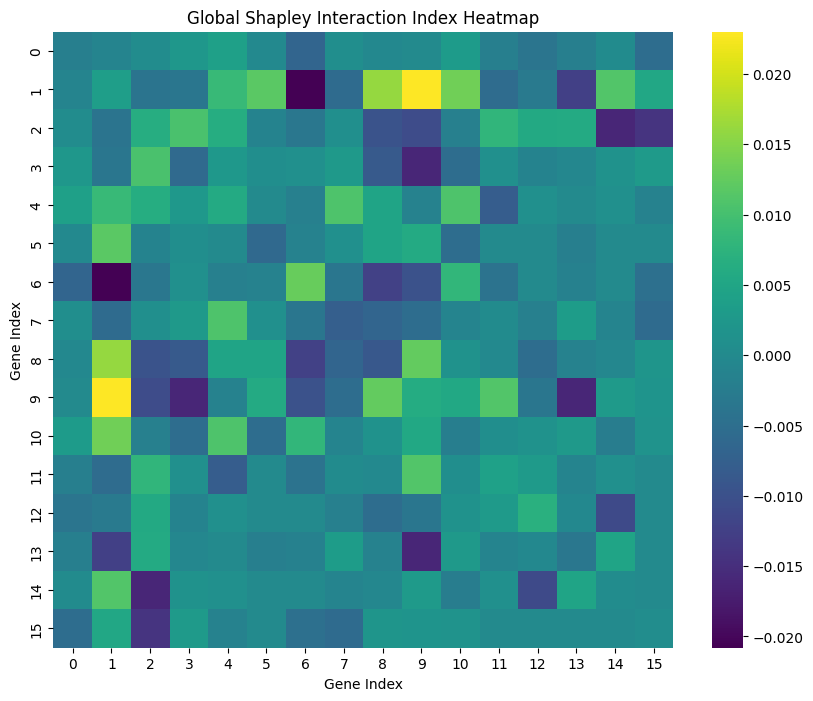

In [55]:
plt.figure(figsize=(10, 8))
sns.heatmap(ii, cmap='viridis',  fmt=".2f")
plt.title('Global Shapley Interaction Index Heatmap')
plt.xlabel('Gene Index')
plt.ylabel('Gene Index')
plt.show()

<Axes: >

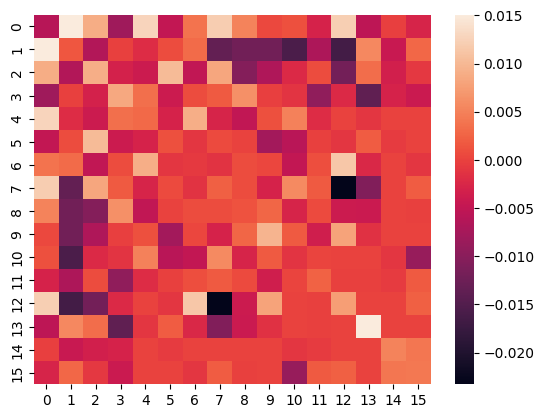

In [152]:
sns.heatmap(ii)

<Axes: >

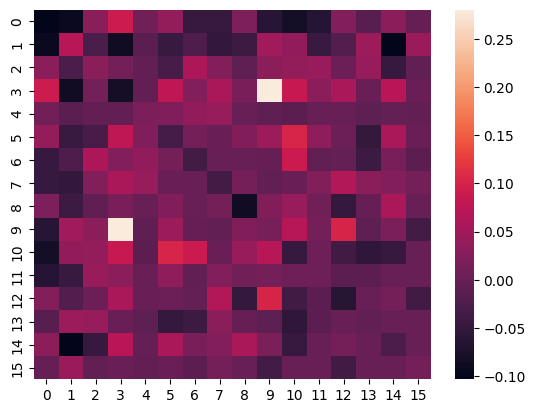

In [96]:
sns.heatmap(maineffect_index)

In [57]:
# Create a mask with zeros in the lower triangle and ones in the upper triangle
mask = torch.triu(torch.ones_like(gene_interaction_index), diagonal=1)

# Multiply the interaction_index by the mask
upper_interaction_index = gene_interaction_index * mask

## Residual Permutation Dataset

Should I permute just over test set and train set seperatley or together.

In [146]:
def compute_residual_labels(main_effect, x, y, device):
    main_effect.to(device)
    x = x.to(device)
    y = y.to(device)
    main_effect.eval()
    with torch.no_grad():
        # can add this in if we need to use a dataloader for bigger datasets
       # dl = DataLoader(TensorDataset(x, y.unsqueeze(1)), batch_size=16, shuffle=True)
        outputs, _ = main_effect(x)
        print(outputs)
    residuals = y- outputs.squeeze()
    print(residuals)
    return residuals, outputs.squeeze()

In [147]:
def generate_permutated_dataset(main_effect, x,y, device):
    residuals, outputs = compute_residual_labels(main_effect, x, y, device)
    permutation = torch.randperm(residuals.shape[0])
    permuted_residuals = residuals[permutation]
    
    permuted_y = permuted_residuals + outputs
    return permuted_y

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [148]:
permuted_y = generate_permutated_dataset(maineffect_model, x, y, device)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([ 0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.,  0., -1.,  1.,  1., -1.,
        -1., -1., -1.], device='cuda:0')


In [141]:
y.shape

torch.Size([17])

In [142]:
permuted_y.shape

torch.Size([17])

In [143]:
permuted_y

tensor([ 0., -1., -1., -1., -1.,  1.,  1.,  2.,  1.,  0.,  1.,  0., -1.,  0.,
         0.,  0.,  2.], device='cuda:0')